# Homework 2 
### Ziying Wang

## Question 2 Pong-V0

In [49]:
import gym
import random
import numpy as np
import tensorflow as tf
#import tflearn
#from tflearn.layers.core import input_data, dropout, fully_connected
#from tflearn.layers.estimator import regression
#from statistics import mean, median
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
#Baseline
class Baseline():
    def __init__(self, learning_rate=0.01, state_size=6400, action_size=2, output_size=1, 
                 hidden_state_size=16, name="Baseline"):
        with tf.name_scope(name):
            self.input_state = tf.placeholder(tf.float32, [None, 80, 80, 2], name = "input")
            self.reward_ = tf.placeholder(tf.float32, [None, ], name = "discounted_episodes_rewards")
            self.conv1 = tf.layers.conv2d(self.input_state, filters = 3, kernel_size = 5, 
                                        activation = tf.nn.relu, 
                                        kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                        name = 'features',
                                        reuse=True
                                        )
            self.pool = tf.layers.max_pooling2d(inputs = self.conv1, pool_size = [2,2], strides=2)
            self.pool_flat = tf.reshape(self.pool, [-1, 38*38*3])
            
            self.fc1 = tf.contrib.layers.fully_connected(self.pool_flat, hidden_state_size, 
                                                        weights_initializer = tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_state_size, 
                                                        weights_initializer = tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 1, 
                                                        weights_initializer = tf.contrib.layers.xavier_initializer())
        
        with tf.name_scope("baseline_train"):
            self.loss = tf.reduce_mean(tf.square(self.fc3 - self.reward_))
            self.train = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            

In [115]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80,80])

In [116]:
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0.0
    for i in reversed(range(len(r))):
        running_add = running_add * gamma + r[i]
        discounted_r[i] = running_add
    discounted_r -= np.mean(discounted_r)
    discounted_r /= np.std(discounted_r)
    return discounted_r

In [122]:
class PolicyGradient():
    def __init__(self, learning_rate = 0.01, action_size = 2, hidden_state_size = 16, name = "PolicyGradient"):
        
        with tf.name_scope(name):
            self.input_state = tf.placeholder(tf.float32, [None, 80, 80, 2], name = "input")
            self.actions_ = tf.placeholder(tf.int32, [None, action_size], name = "actions")
            self.rewards_ = tf.placeholder(tf.float32, [None, ], name = "discounted_episodes_rewards")
            
            self.conv1 = tf.layers.conv2d(self.input_state, filters = 3, kernel_size = 5, activation = tf.nn.relu,
                                         kernel_initializer = tf.contrib.layers.xavier_initializer(),name = "features")
            
            self.pool = tf.layers.max_pooling2d(inputs = self.conv1, pool_size = [2,2], strides=2)
            self.pool_flat = tf.reshape(self.pool, [-1, 38*38*3])
            
            self.fc1 = tf.contrib.layers.fully_connected(self.pool_flat, hidden_state_size, 
                                                        weights_initializer = tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_state_size, 
                                                        weights_initializer = tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                        weights_initializer = tf.contrib.layers.xavier_initializer(),
                                                        activation_fn=None)

            self.softmax = tf.nn.softmax(self.fc3)
        with tf.name_scope("loss"):
            self.xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.actions_, logits=self.fc3)
            self.loss_op = tf.reduce_mean(self.rewards_*self.xentropy)
        with tf.name_scope("train"):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            self.train_op = self.optimizer.minimize(self.loss_op)
            
            

In [123]:

env = gym.make('Pong-v0')

obs = env.reset()
actions = ['RIGHT','LEFT']
n_actions = len(actions)
gamma = 0.99

n_epochs = 2000
tf.reset_default_graph()
PolicyGradient_nn = PolicyGradient(hidden_state_size=10)
baseline_nn = BaselineFunction(hidden_state_size=10)

env = gym.make('Pong-v0')
env.reset()

all_rewards = []
saver = tf.train.Saver()


In [ ]:
with tf.Session() as sess:
    
#     saver = tf.train.import_meta_graph('./model.ckpt.meta') #import the model trained for Cartpole
#     saver.restore(sess, 'model.ckpt')
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        
        
        
        rewards = []
        discounted_rewards = []
        observations = []
        actions = []
        
        state = env.reset()
        
        prev_state = preprocess(state)
        curr_state = preprocess(env.step(0)[0])
        
        epoch_rewards = []
        
        while True:   
            concat_state = np.concatenate((curr_state, prev_state)).reshape([-1, 80, 80, 2])
#             print("OK?")
#             print("prev shape:", np.concatenate((curr_state, prev_state)).shape)
#             print("shape: ", concat_state.shape)
            action_prob = sess.run(PolicyGradient_nn.softmax, feed_dict={PolicyGradient_nn.input_state:concat_state})
#             print("debug")
            action = np.random.choice(range(n_actions), p=action_prob.ravel())
            one_hot_action = np.zeros(n_actions)
            one_hot_action[action] = 1
            obs, reward, done, info = env.step(2 + action)
            rewards.append(reward)
            observations.append(state)
            actions.append(action)
            
            rewards.append(reward)
            observations.append(concat_state)
            actions.append(one_hot_action)
            
            prev_state = curr_state
            curr_state = preprocess(obs)
            
            if done:
                discounted_reward = discount_rewards(rewards)
                
                baseline_ = sess.run(baseline_nn.fc3, feed_dict = {baseline_nn.inputs_: np.vstack(observations)})
                b = discounted_reward - np.hstack(baseline_)
                
                _,_ = sess.run([baseline_nn.loss, baseline_nn.train],
                               feed_dict = {baseline_nn.input_state: np.vstack(np.array(observations)),
                                           baseline_nn.reward_:discounted_reward
                                           }) 
                
                _,_ = sess.run([policy_network.loss, policy_network.train], 
                                    feed_dict={PolicyGradient_nn.input_state: np.vstack(observations),
                                                                 PolicyGradient_nn.actions_: actions,
                                                                 PolicyGradient_nn.reward_: b
                                                                })
                break
            
            state = obs
            
        all_rewards.append(sum(rewards))
        
        if epoch % 100 == 0:
            with open('result.txt','a') as f:
                f.write("\n Epoch: %s    Length: %s    Reward: %s    L50 Reward: %s" %(epoch, len(rewards), all_rewards[epoch], np.mean(all_rewards[epoch-50:epoch])))
        

In [1]:
import re
import matplotlib.pyplot as plt

In [8]:
with open('result.txt') as f:
    lines = f.readlines()[1:]
    
epoch = [re.findall('L50 Reward: ([0-9.-]*)', x) for x in lines]
avg_reward = [re.findall('L50 Reward: ([0-9.-]*)', x) for x in lines]
epochs = [int(x.split()[1]) for x in lines]
game_len = [int(x.split()[3]) for x in lines]
avg_reward = [float(x.split()[8]) for x in lines]

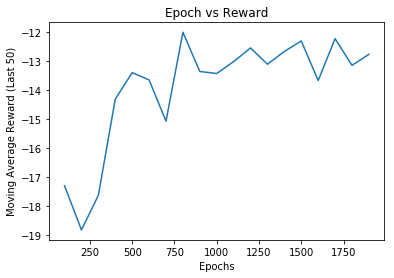

In [11]:
plt.plot(epochs, avg_reward)
plt.xlabel('Epochs')
plt.ylabel('Moving Average Reward (Last 50)')
plt.title('Epoch vs Reward')
plt.savefig('epoch_vs_reward.png')

In [ ]:
import